In [6]:
import os

import dotenv

dotenv.load_dotenv()
from pprint import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb
import yaml

sb.set_theme()

metrics_df

In [3]:
def open_experiment(name: str):
    exp_dir = f"../../experiments/{name}/runs"
    experiments = os.listdir(exp_dir)
    full_df = []
    miss_metric = [
        "flops_test",
        "flops_train",
        "max_test_memory",
        "max_train_memory",
        "number_parameters",
    ]
    for exp in experiments:
        metrics = os.path.join(exp_dir, exp, "version_0", "metrics.csv")
        hparams_file = os.path.join(exp_dir, exp, "version_0", "hparams.yaml")
        summary_file = os.path.join(exp_dir, exp, "version_0", "summary.yaml")

        if os.path.exists(metrics) and os.path.exists(hparams_file):
            with open(hparams_file, "r") as f:
                hparams = yaml.load(f, Loader=yaml.FullLoader)
            with open(summary_file, "r") as f:
                summary = yaml.load(f, Loader=yaml.FullLoader)
            metrics_df = pd.read_csv(metrics)
            if len(metrics_df)==0:
                print(metrics)
                continue
            metrics_series = metrics_df.iloc[-1].copy()
            for key in miss_metric:
                if key in metrics_df:
                    col = metrics_df[key].dropna()
                    if len(col) > 0:
                        metrics_series[key] = col.iloc[-1]
            for key, value in hparams["config"].items():
                metrics_series[key] = value
            metrics_series["start_datetime"]= pd.to_datetime(summary["start_datetime"])
            metrics_series["end_datetime"]= summary.get("end_datetime", pd.NA)

            full_df.append(metrics_series)
    full_df= pd.DataFrame(full_df).dropna(subset="test_bpd")
    full_df["end_datetime"]= pd.to_datetime(full_df["end_datetime"])
    if "kernel_size" in full_df:
        full_df["kernel_size"] = full_df["kernel_size"].apply(lambda x: x[0])
    return full_df

def open_raw_metrics(name:str):
    exp_dir = f"../../experiments/{name}/runs"
    experiments = os.listdir(exp_dir)
    full_df = []
    for exp in experiments:
        metrics = os.path.join(exp_dir, exp, "version_0", "metrics.csv")
        hparams_file = os.path.join(exp_dir, exp, "version_0", "hparams.yaml")
        summary_file = os.path.join(exp_dir, exp, "version_0", "summary.yaml")

        if os.path.exists(metrics) and os.path.exists(hparams_file):
            with open(hparams_file, "r") as f:
                hparams = yaml.load(f, Loader=yaml.FullLoader)
            with open(summary_file, "r") as f:
                summary = yaml.load(f, Loader=yaml.FullLoader)
            metrics_df = pd.read_csv(metrics)
            if len(metrics_df)==0:
                print(metrics)
                continue
            for key, value in hparams["config"].items():
                
                metrics_df[key] = pd.Series([value] * len(metrics_df))
            metrics_df["start_datetime"]= pd.to_datetime(summary["start_datetime"])
            metrics_df["end_datetime"]= summary.get("end_datetime", pd.NA)

            full_df.append(metrics_df)
    full_df= pd.concat(full_df)
    full_df["end_datetime"]= pd.to_datetime(full_df["end_datetime"])
    if "kernel_size" in full_df:
        full_df["kernel_size"] = full_df["kernel_size"].apply(lambda x: x[0])
    return full_df


In [7]:
results_mnist = open_experiment("bench-mnist")
results_cifar = open_experiment("bench-cifar")
results = pd.concat([results_mnist, results_cifar])


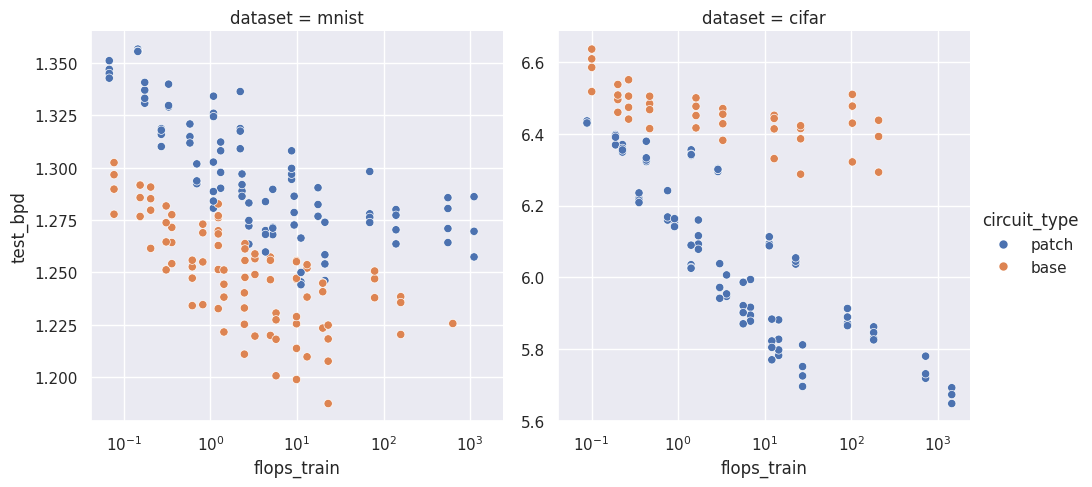

In [7]:
sb.relplot(
    results,
    x="flops_train",
    y="test_bpd",
    hue="circuit_type",
    col="dataset",
    facet_kws=dict(sharey=False),
)
plt.xscale("log")

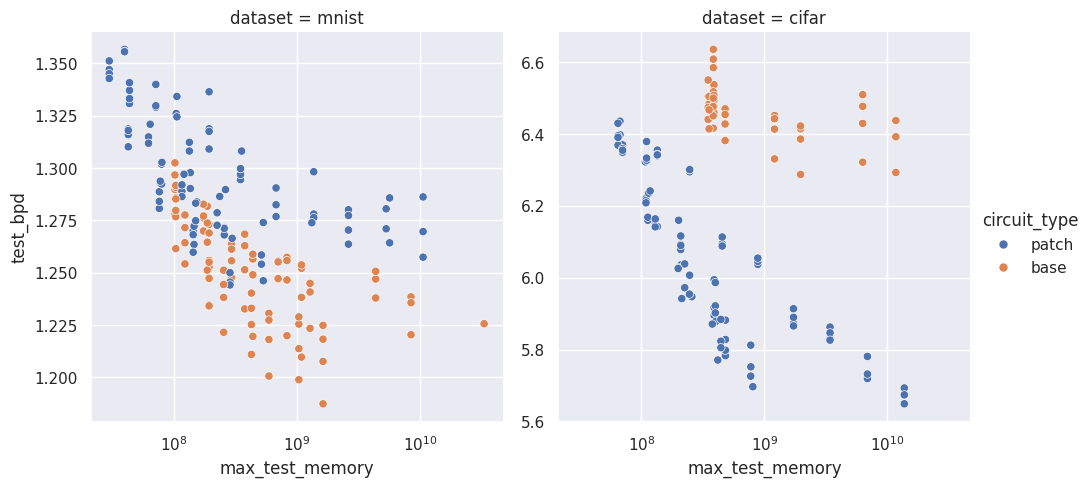

In [8]:
sb.relplot(
    results,
    x="max_test_memory",
    y="test_bpd",
    hue="circuit_type",
    col="dataset",
    facet_kws=dict(sharey=False),
)
plt.xscale("log")

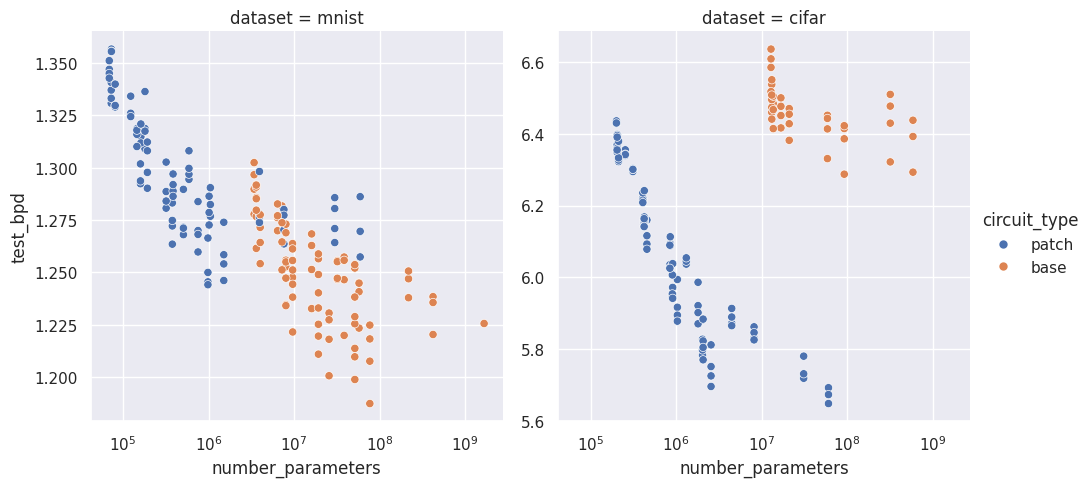

In [9]:
sb.relplot(
    results,
    x="number_parameters",
    y="test_bpd",
    hue="circuit_type",
    col="dataset",
    facet_kws=dict(sharey=False),
)
plt.xscale("log")

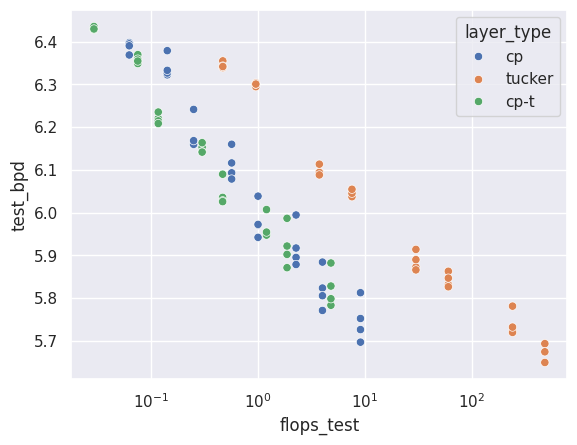

In [10]:
patch_only = results_cifar[results_cifar["circuit_type"] == "patch"]

sb.scatterplot(patch_only, x="flops_test", y="test_bpd", hue="layer_type")
plt.xscale("log")

In [11]:
results[(results["dataset"]=="cifar")].sort_values("test_loss", ascending=False)[
    [
        "circuit_type",
        "layer_type",
        "lr",
        "num_units",
        "region_graph",
        "dataset",
        "test_bpd",
        "epoch",
        "test_loss"
    ]
]

,circuit_type,layer_type,lr,num_units,region_graph,dataset,test_bpd,epoch,test_loss
214,base,cp-t,0.001,16,quad-tree-2,cifar,6.635146,54.0,14128.536133
88,base,cp-t,0.005,16,quad-tree-2,cifar,6.607981,22.0,14070.692383
64,base,cp-t,0.010,16,quad-tree-2,cifar,6.584209,16.0,14020.073242
336,base,cp-t,0.001,16,quad-graph,cifar,6.549833,85.0,13946.875000
355,base,cp,0.001,16,quad-tree-2,cifar,6.536796,90.0,13919.114258
...,...,...,...,...,...,...,...,...,...
167,patch,tucker,0.050,128,quad-tree-2,cifar,5.719538,42.0,12178.887695
253,patch,cp,0.050,128,quad-graph,cifar,5.696716,64.0,12130.291992
395,patch,tucker,0.005,128,quad-graph,cifar,5.693235,100.0,12122.878906
391,patch,tucker,0.010,128,quad-graph,cifar,5.674138,99.0,12082.214844


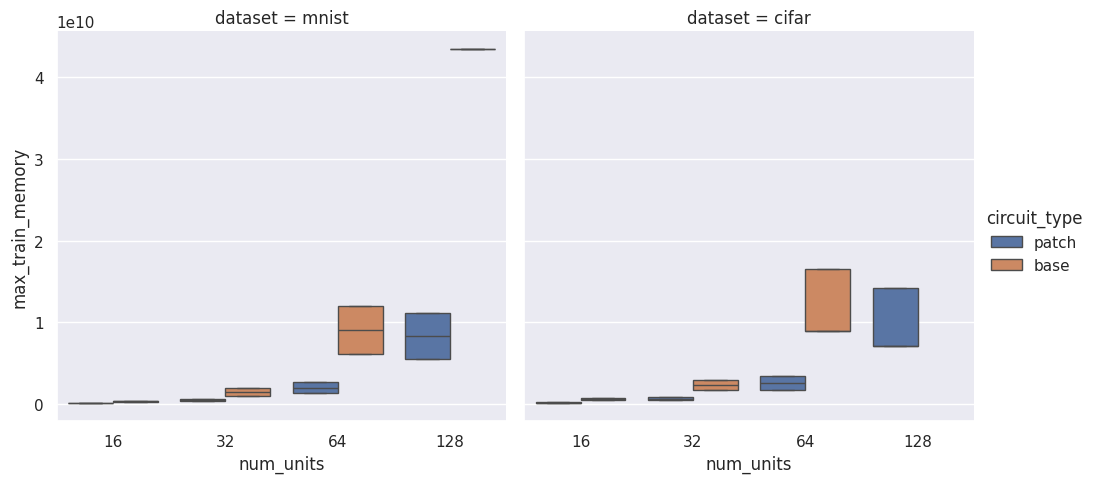

In [11]:
tucker = results[results["layer_type"] == "tucker"]
sb.catplot(
    tucker,
    y="max_train_memory",
    x="num_units",
    hue="circuit_type",
    col="dataset",
    kind="box",
)

## High Conf Benchmark

In [4]:
results_high = open_experiment("bench-high-conf")
# results_high=pd.concat([results, results_high])
results_high.columns

Index(['epoch', 'flops_test', 'flops_train', 'max_test_memory',
       'max_train_memory', 'number_parameters', 'step', 'test_bpd',
       'test_loss', 'train_loss', 'val_loss', 'batch_size', 'channel',
       'circuit_type', 'dataset', 'experiment_path', 'image_size',
       'kernel_size', 'layer_type', 'lr', 'num_units', 'region_graph',
       'start_datetime', 'end_datetime'],
      dtype='object')

In [34]:
results_high[(results_high["dataset"]=="cifar")].sort_values("test_loss", ascending=False)[
    [
        "circuit_type",
        "layer_type",
        "lr",
        "num_units",
        "region_graph",
        "dataset",
        "test_bpd",
        "epoch",
        "test_loss"
    ]
]

,circuit_type,layer_type,lr,num_units,region_graph,dataset,test_bpd,epoch,test_loss
365,base,cp-t,0.01,128,quad-tree-2,cifar,6.495518,12.0,13831.218750
335,base,cp-t,0.01,256,quad-tree-2,cifar,6.480038,11.0,13798.255859
305,base,cp-t,0.01,512,quad-tree-2,cifar,6.470581,10.0,13778.119141
153,base,cp-t,0.05,512,quad-tree-2,cifar,6.427962,5.0,13687.370117
183,base,cp-t,0.05,256,quad-tree-2,cifar,6.420743,6.0,13671.996094
214,base,cp-t,0.05,128,quad-tree-2,cifar,6.417144,7.0,13664.333008
426,base,cp-t,0.01,128,quad-graph,cifar,6.406626,14.0,13641.937500
365,base,cp-t,0.01,256,quad-graph,cifar,6.395725,12.0,13618.724609
335,base,cp-t,0.01,512,quad-graph,cifar,6.388948,11.0,13604.294922
486,base,cp,0.01,128,quad-tree-2,cifar,6.349650,16.0,13520.615234


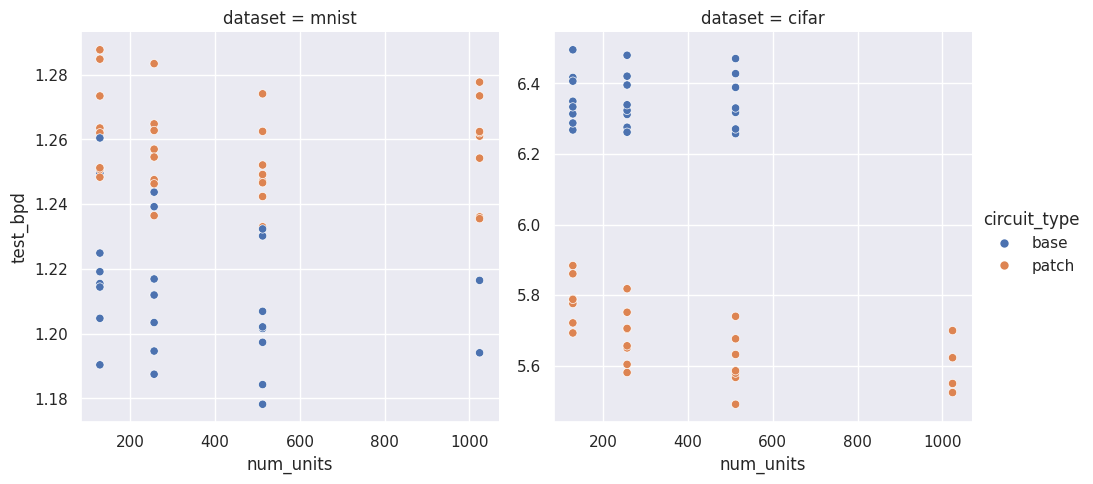

In [13]:
sb.relplot(
    results_high,
    y="test_bpd",
    x="num_units",
    hue="circuit_type",
    col="dataset",
    facet_kws=dict(sharey=False),
)

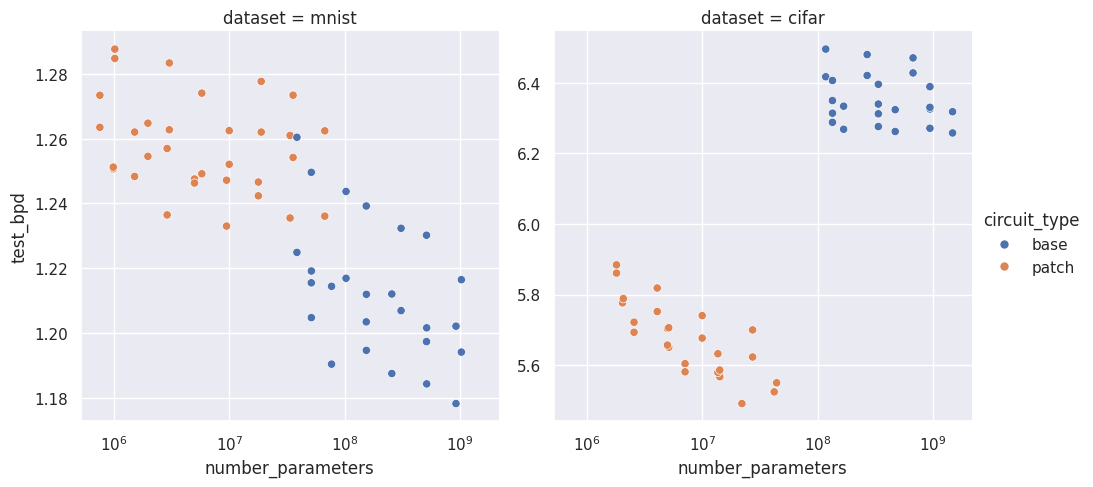

In [14]:
sb.relplot(
    results_high,
    x="number_parameters",
    y="test_bpd",
    hue="circuit_type",
    col="dataset",
    facet_kws=dict(sharey=False),
)
plt.xscale("log")

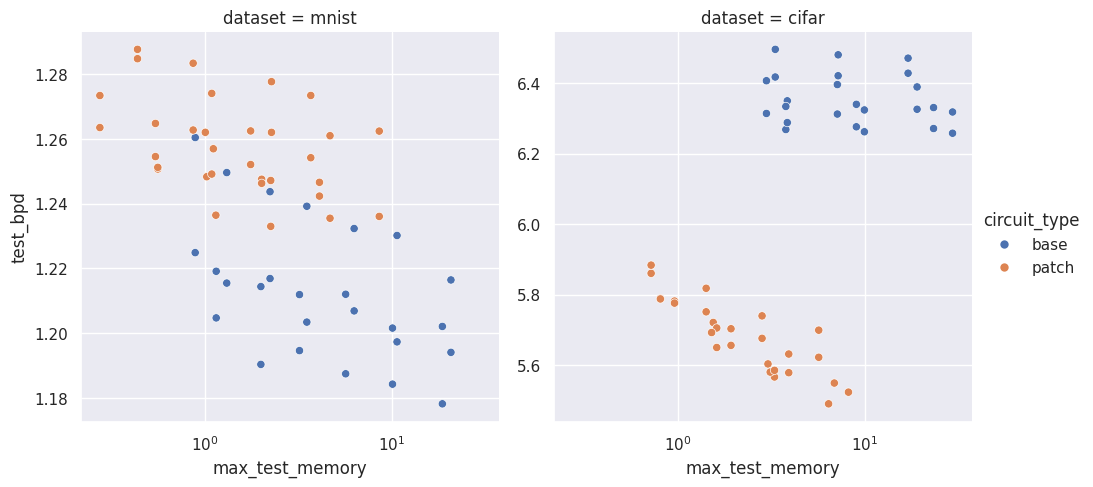

In [15]:
sb.relplot(
    results_high,
    x="max_test_memory",
    y="test_bpd",
    hue="circuit_type",
    col="dataset",
    facet_kws=dict(sharey=False),
)
plt.xscale("log")

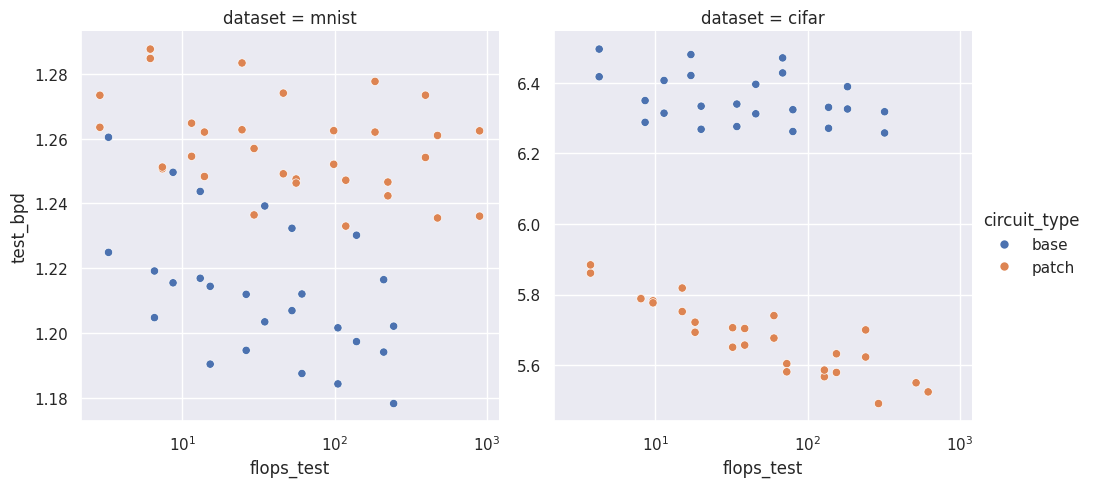

In [16]:
sb.relplot(
    results_high,
    x="flops_test",
    y="test_bpd",
    hue="circuit_type",
    col="dataset",
    facet_kws=dict(sharey=False),
)
plt.xscale("log")

In [17]:
x = np.array([128, 256, 512], dtype=float)
y = np.array([5.948062, 14.374174, 38.774566], dtype=float)

# transform
Y = np.log(y)

# linear fit
b, ln_a = np.polyfit(x, Y, 1)
a = np.exp(ln_a)

print("a =", a)
print("b =", b)

# Predict next step (x=1024)
x_next = 1024
y_next = a * np.exp(b * x_next)
print("Predicted y for 1024:", y_next)


a = 3.6215414719644405
b = 0.004738352482188071
Predicted y for 1024: 463.57709245870336


In [18]:
a * np.exp(b * 1024)/16

np.float64(28.97356827866896)

In [19]:
512/16

32.0

In [20]:
grouped = results_high[(results_high["dataset"]=="mnist") & (results_high["circuit_type"]=="base")].groupby(["num_units"]).max()["max_train_memory"]
np.log(grouped)
grouped/1e9

num_units
128      2.924737
256      8.337304
512     26.700649
1024    26.691484
Name: max_train_memory, dtype: float64

## Patch Size Sensibility

In [ ]:
results_patch =pd.concat([open_experiment("bench-patch-mnist"), open_experiment("bench-patch-cifar")])


results_patch = results_patch.reset_index(drop=True)

In [22]:

def plot_patch(df, x, y):
    datasets = results_patch["dataset"].unique()
    fig, axes = plt.subplots(1, len(datasets), figsize=(6*len(datasets), 5), sharey=False)

    for ax, ds in zip(axes, datasets):
        subdf = results_patch[results_patch["dataset"] == ds]
        
        sb.scatterplot(
            data=subdf,
            x=x,
            y=y,
            hue="kernel_size",
            ax=ax,
            s=50
        )
        ax.set_title(ds)
        ax.set_xscale("log")
        
        # Move legend outside the plot
        ax.legend(
            title="patch",
            bbox_to_anchor=(1.05, 1),
            loc="upper left"
        )

    plt.tight_layout()
    plt.show()


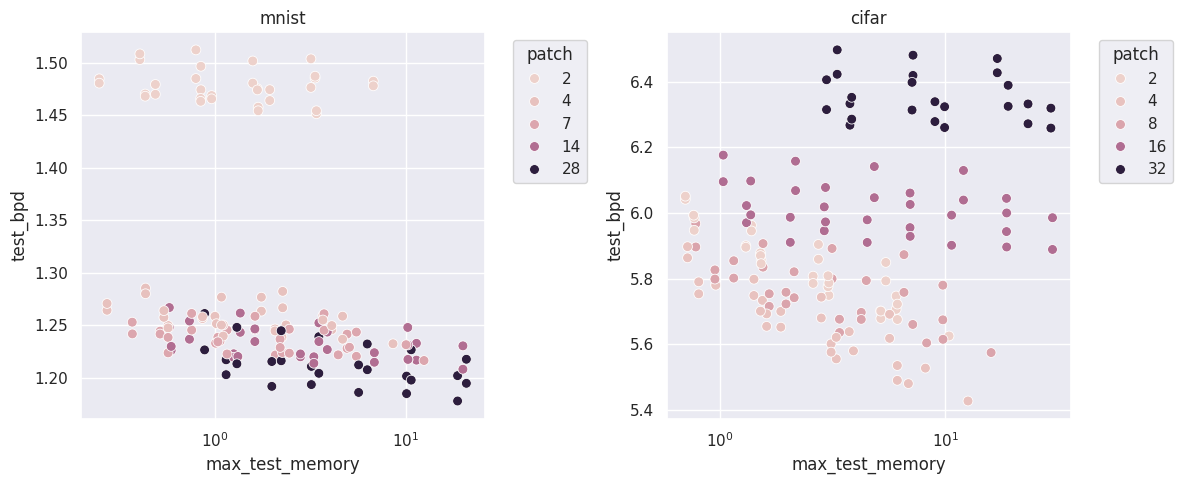

In [23]:
plot_patch(results_patch, x="max_test_memory", y="test_bpd")

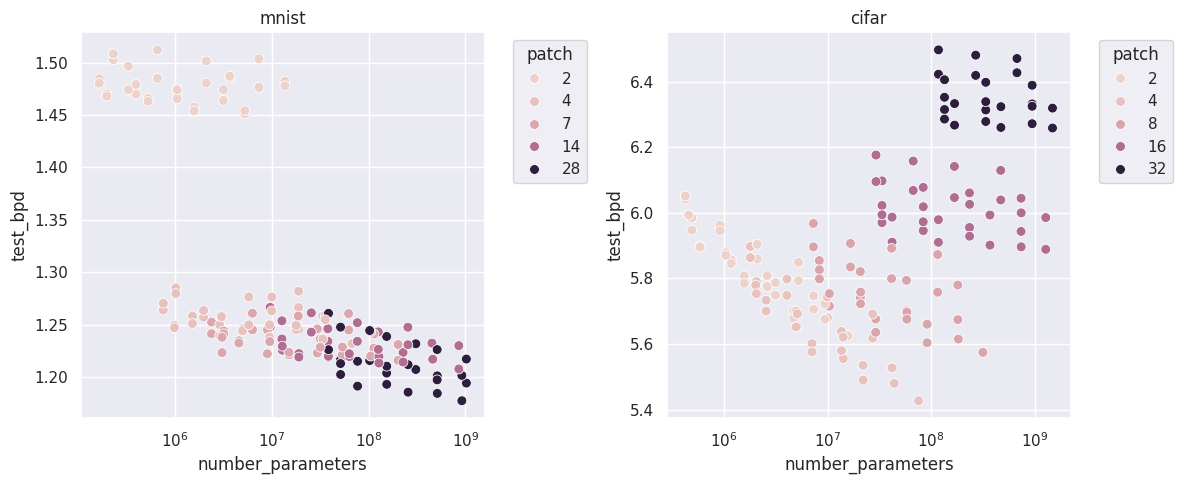

In [24]:

plot_patch(results_patch, x="number_parameters", y="test_bpd")


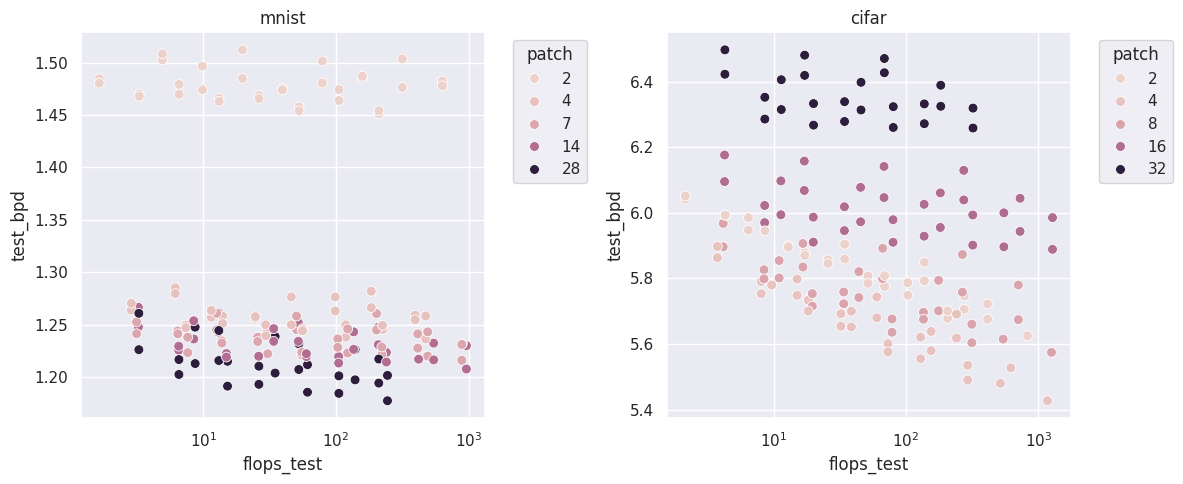

In [25]:
plot_patch(results_patch, x="flops_test", y="test_bpd")


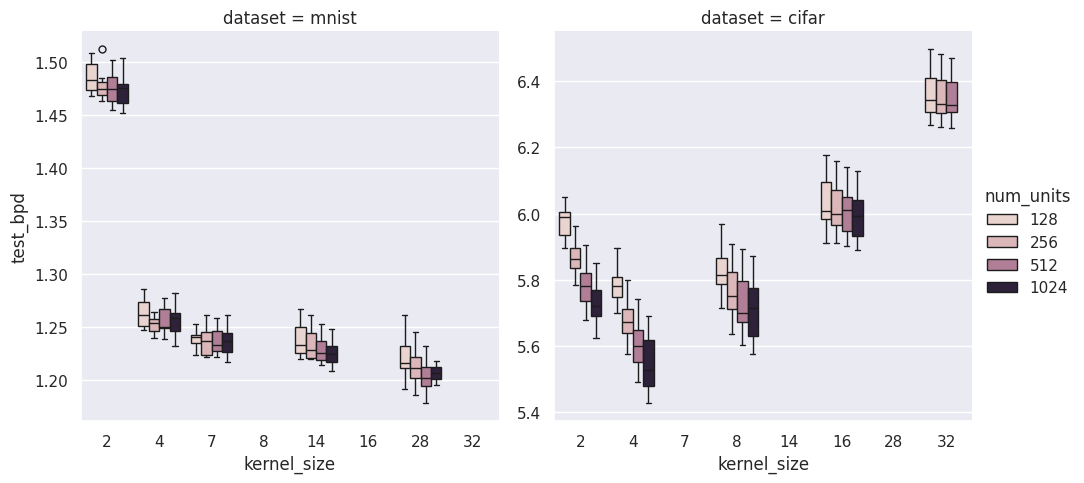

In [26]:
sb.catplot(results_patch, x="kernel_size", y="test_bpd",kind="box", hue="num_units", col="dataset",sharey=False)

In [27]:
results_patch[results_patch["kernel_size"] == 2]["num_units"]

12      512
23     1024
24     1024
26     1024
36      256
       ... 
290     256
293    1024
294     256
296     128
298     256
Name: num_units, Length: 63, dtype: int64

## Patch Celeb-A

In [26]:
import matplotlib.ticker
from matplotlib.colors import LogNorm, Normalize
results_patch =pd.concat([open_experiment("bench-patch-celebA"), open_experiment("bench-patch-imagenet")])

results_patch = results_patch.reset_index(drop=True)

In [29]:
results_patch[results_patch["dataset"]=="celeba"].sort_values("test_loss")

,epoch,flops_test,flops_train,max_test_memory,max_train_memory,number_parameters,step,test_bpd,test_loss,train_loss,...,early_stopping_delta,experiment_path,image_size,kernel_size,layer_type,lr,num_units,region_graph,start_datetime,end_datetime
139,38.0,1254.138847,3762.416542,16.006115,20.439099,3.146158e+08,193306.0,4.856205,41362.207031,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",8,cp,0.05,1024,quad-graph,2025-11-26 21:57:05.758875,2025-11-27 19:29:36.780982
92,64.0,1168.264692,3504.794075,13.539695,14.633486,7.550771e+07,325568.0,4.874300,41516.324219,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",4,cp,0.01,1024,quad-graph,2025-11-26 23:05:16.906992,2025-11-27 20:53:44.917723
121,33.0,1168.264692,3504.794075,12.633591,14.633485,7.550771e+07,167871.0,4.875109,41523.214844,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",4,cp,0.05,1024,quad-graph,2025-11-26 21:32:09.595184,2025-11-27 11:20:50.811306
75,30.0,618.508878,1855.526633,7.666485,8.181596,4.195328e+07,152610.0,4.937946,42058.421875,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",4,cp-t,0.05,1024,quad-graph,2025-11-25 11:24:16.577040,2025-11-25 18:58:38.403159
109,36.0,704.383033,2113.149100,9.763939,11.940388,1.803981e+08,183132.0,4.938610,42064.078125,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",8,cp-t,0.05,1024,quad-graph,2025-11-25 11:28:37.234462,2025-11-25 22:55:40.883039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,8.0,4.311876,12.935627,0.761153,0.776750,4.590100e+05,40696.0,5.593418,47641.332031,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",2,cp-t,0.05,128,quad-graph,2025-11-25 08:22:18.862488,2025-11-25 08:33:24.401273
6,6.0,4.292878,12.878635,12.571096,12.593624,4.697294e+08,30522.0,5.607379,47760.246094,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",64,cp-t,0.05,128,quad-tree-2,2025-11-25 14:49:22.813725,2025-11-25 16:24:42.162510
36,7.0,17.171497,51.514491,23.638195,27.292041,1.073611e+09,35609.0,5.631665,47967.101562,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",64,cp-t,0.01,256,quad-tree-2,2025-11-25 20:04:33.403417,2025-11-25 23:58:23.718517
26,14.0,2.155872,6.467617,0.699410,0.573714,4.261120e+05,71218.0,5.677686,48359.082031,NaN,...,10,experiments/bench-patch-celebA/,"(64, 64)",2,cp-t,0.01,128,quad-tree-2,2025-11-25 15:07:37.023433,2025-11-25 15:28:15.433422


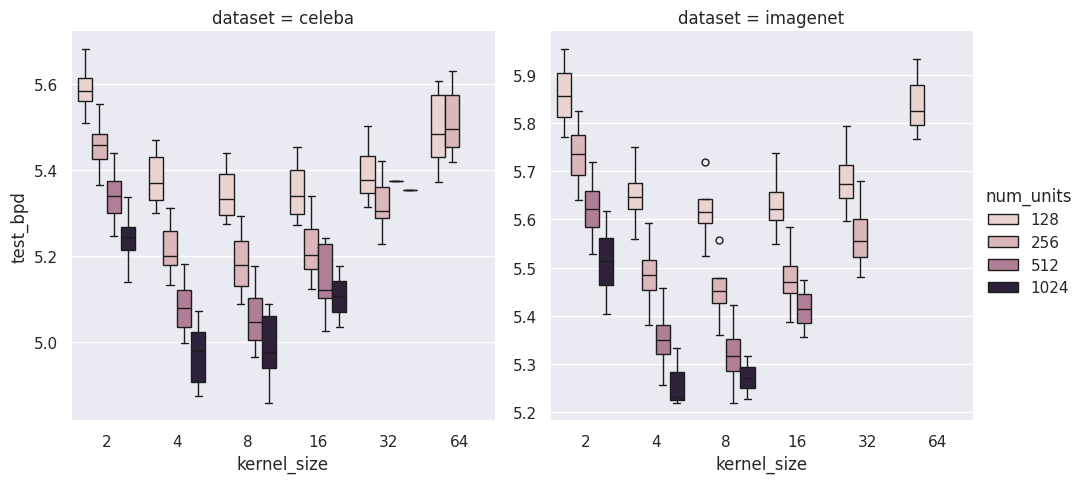

In [29]:
sb.catplot(results_patch, x="kernel_size", y="test_bpd",kind="box", hue="num_units", col="dataset",sharey=False)

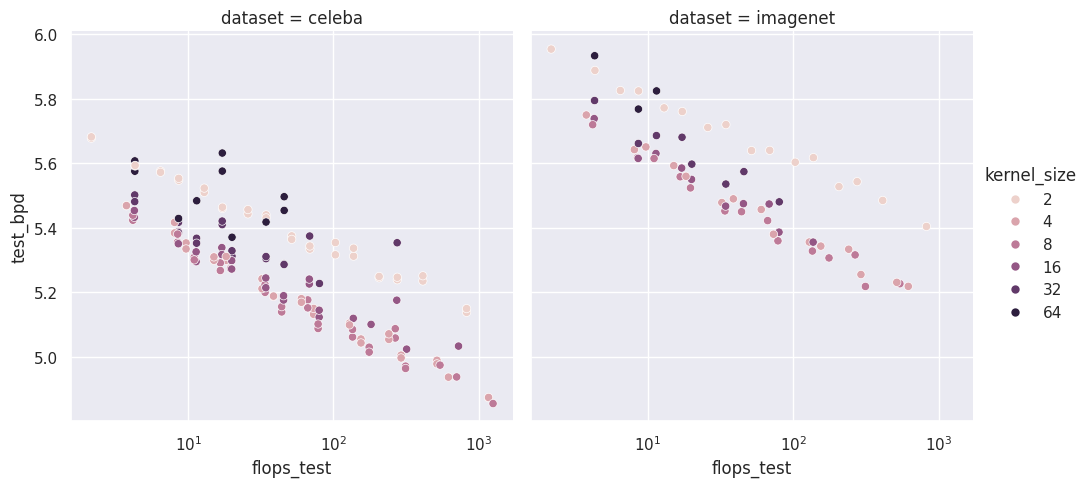

In [30]:
g_results=sb.relplot(results_patch, x="flops_test", y="test_bpd", col="dataset", hue="kernel_size", hue_norm=LogNorm())
g_results.set(xscale='log')


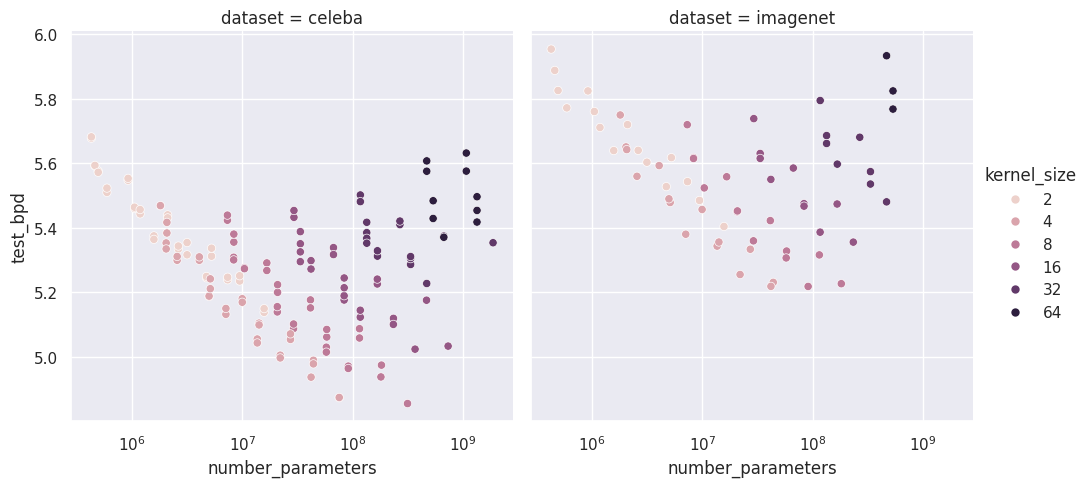

In [31]:
g_results=sb.relplot(results_patch, x="number_parameters", y="test_bpd", col="dataset", hue="kernel_size",  hue_norm=LogNorm())
g_results.set(xscale='log')

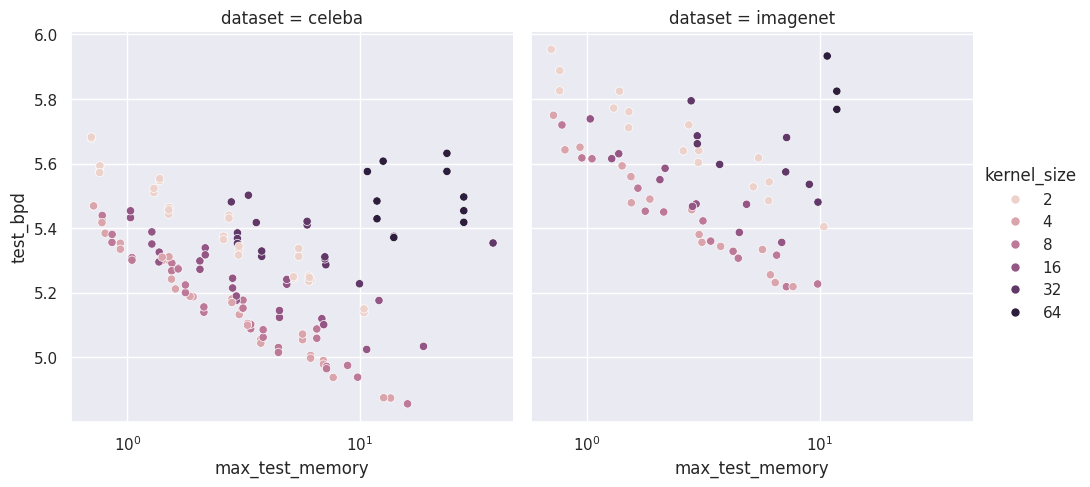

In [32]:
g_results=sb.relplot(results_patch, x="max_test_memory", y="test_bpd", col="dataset", hue="kernel_size",  hue_norm=LogNorm())
g_results.set(xscale='log')

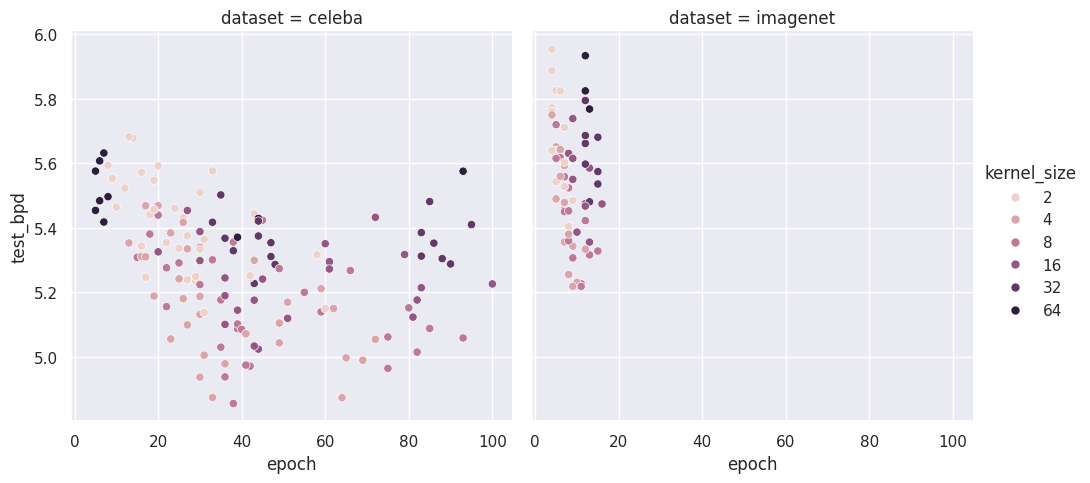

In [33]:
g_results=sb.relplot(results_patch, x="epoch", y="test_bpd", col="dataset", hue="kernel_size", hue_norm=LogNorm())
# g_results.set(xscale='log')

## Colour Transform

In [32]:
import matplotlib.ticker
from matplotlib.colors import LogNorm, Normalize

results_patch = pd.concat([open_experiment("bench-patch-celebA"), open_experiment("bench-patch-imagenet"), open_experiment("bench-colour-patch-64")])

results_patch["runtime"]=results_patch["end_datetime"]-results_patch["start_datetime"]
results_patch.loc[results_patch["colour_transform"].isna(), "colour_transform"]="none"

results_patch = results_patch.reset_index(drop=True)

In [57]:
results_patch[results_patch["dataset"]=="celeba"].sort_values("test_bpd")

,epoch,flops_test,flops_train,max_test_memory,max_train_memory,number_parameters,step,test_bpd,test_loss,train_loss,...,image_size,kernel_size,layer_type,lr,num_units,region_graph,start_datetime,end_datetime,colour_transform,runtime
271,20.0,704.383033,2113.149100,9.763939,12.317875,1.803981e+08,101720.0,4.650668,39611.562500,NaN,...,"(64, 64)",8,cp-t,0.05,1024,quad-graph,2025-11-30 12:35:46.294162,2025-11-30 18:13:01.467011,ycc_lossless,0 days 05:37:15.172849
216,17.0,618.508878,1855.526633,7.666485,8.793964,4.195328e+07,86462.0,4.655068,39649.042969,NaN,...,"(64, 64)",4,cp-t,0.05,1024,quad-graph,2025-11-30 12:35:45.246175,2025-11-30 16:12:24.902608,ycc_lossless,0 days 03:36:39.656433
265,22.0,725.851572,2177.554717,18.473140,25.157071,7.341773e+08,111892.0,4.726453,40257.058594,NaN,...,"(64, 64)",16,cp-t,0.05,1024,quad-graph,2025-11-30 12:41:21.026582,2025-12-01 00:04:58.456536,ycc_lossless,0 days 11:23:37.429954
208,17.0,176.097862,528.293585,4.459943,5.435383,5.769319e+07,86462.0,4.744568,40411.351562,NaN,...,"(64, 64)",8,cp-t,0.05,512,quad-graph,2025-11-30 10:05:12.964792,2025-11-30 12:08:33.807388,ycc_lossless,0 days 02:03:20.842596
330,15.0,154.635633,463.906898,3.745691,4.246061,1.363661e+07,76290.0,4.760900,40550.453125,NaN,...,"(64, 64)",4,cp-t,0.05,512,quad-graph,2025-11-30 09:58:36.545229,2025-11-30 11:25:14.886281,ycc_lossless,0 days 01:26:38.341052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,8.0,4.311876,12.935627,0.761153,0.776750,4.590100e+05,40696.0,5.593418,47641.332031,NaN,...,"(64, 64)",2,cp-t,0.05,128,quad-graph,2025-11-25 08:22:18.862488,2025-11-25 08:33:24.401273,none,0 days 00:11:05.538785
6,6.0,4.292878,12.878635,12.571096,12.593624,4.697294e+08,30522.0,5.607379,47760.246094,NaN,...,"(64, 64)",64,cp-t,0.05,128,quad-tree-2,2025-11-25 14:49:22.813725,2025-11-25 16:24:42.162510,none,0 days 01:35:19.348785
36,7.0,17.171497,51.514491,23.638195,27.292041,1.073611e+09,35609.0,5.631665,47967.101562,NaN,...,"(64, 64)",64,cp-t,0.01,256,quad-tree-2,2025-11-25 20:04:33.403417,2025-11-25 23:58:23.718517,none,0 days 03:53:50.315100
26,14.0,2.155872,6.467617,0.699410,0.573714,4.261120e+05,71218.0,5.677686,48359.082031,NaN,...,"(64, 64)",2,cp-t,0.01,128,quad-tree-2,2025-11-25 15:07:37.023433,2025-11-25 15:28:15.433422,none,0 days 00:20:38.409989


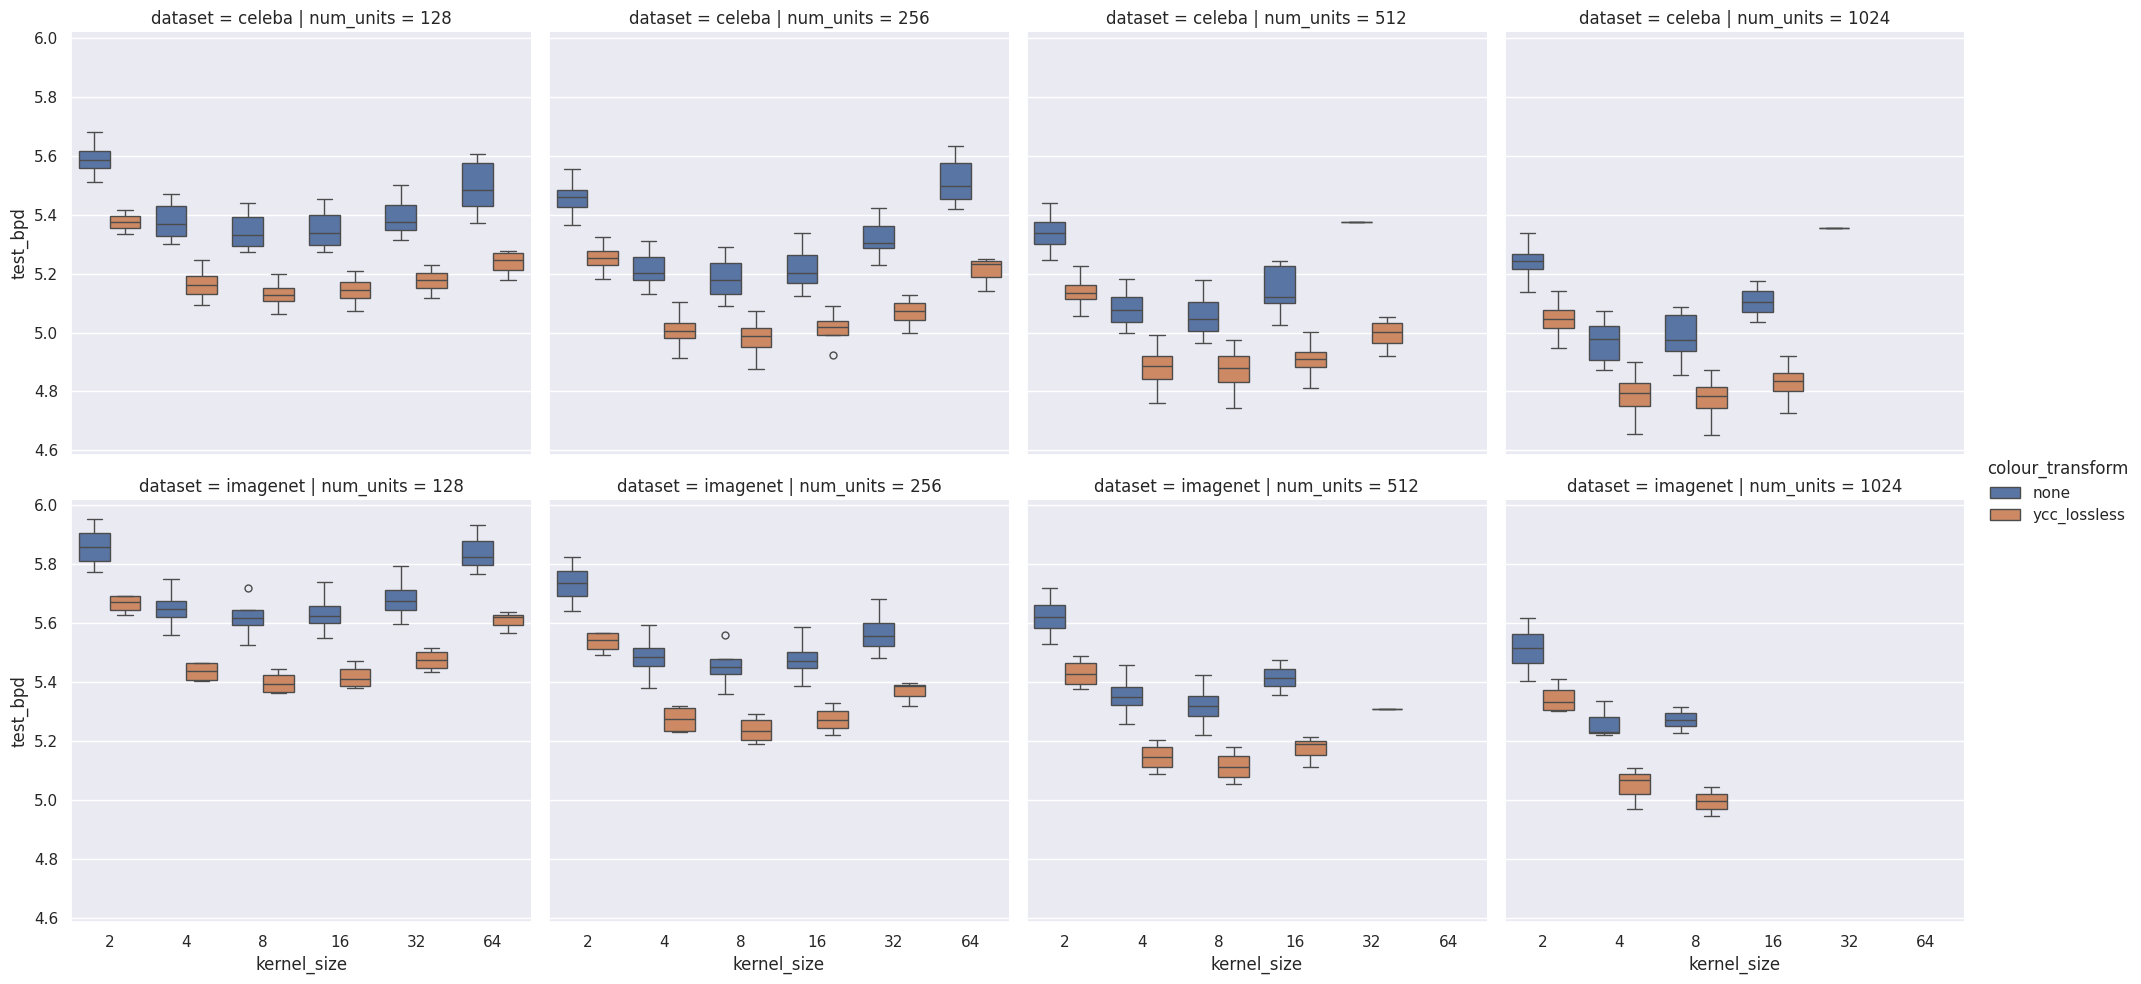

In [35]:
sb.catplot(results_patch, x="kernel_size", y="test_bpd",kind="box", hue="colour_transform", col="num_units", row="dataset", sharey=True)

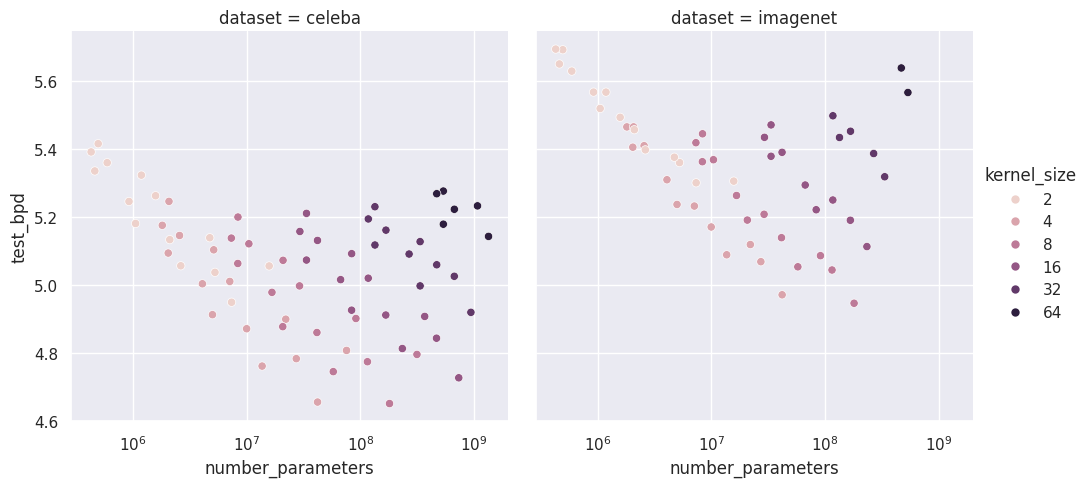

In [70]:
g_results=sb.relplot(results_patch,  x="number_parameters", y="test_bpd", hue="kernel_size", col="dataset",hue_norm=LogNorm())
g_results.set(xscale='log')


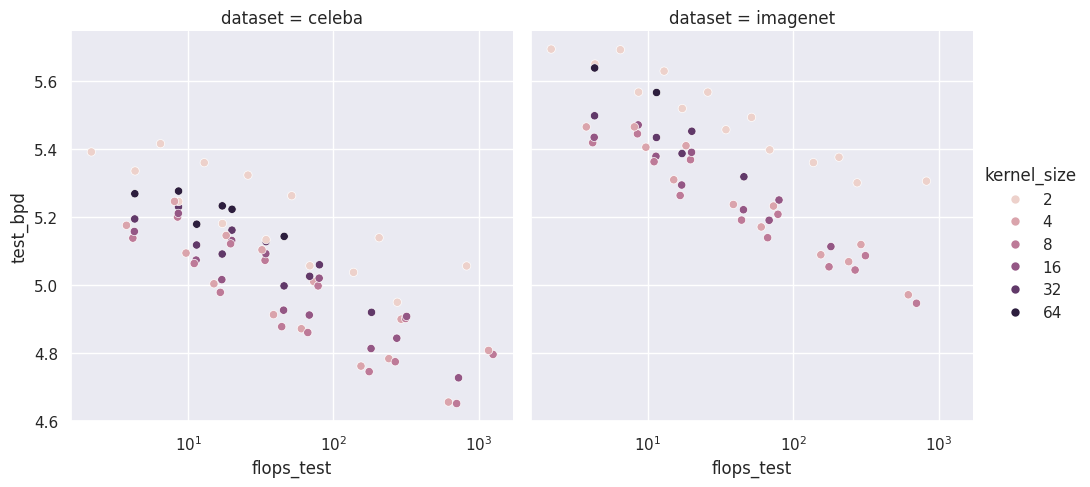

In [68]:
g_results=sb.relplot(results_patch, x="flops_test", y="test_bpd", col="dataset", hue="kernel_size", hue_norm=LogNorm())
g_results.set(xscale='log')


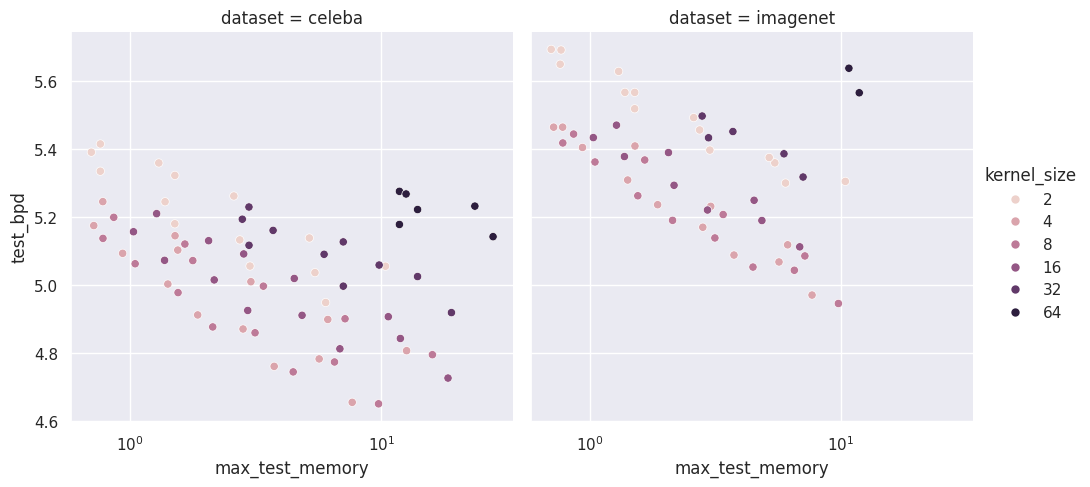

In [69]:
g_results=sb.relplot(results_patch, x="max_test_memory", y="test_bpd", col="dataset", hue="kernel_size", hue_norm=LogNorm())
g_results.set(xscale='log')


In [61]:
metrics = open_raw_metrics("bench-colour-patch-64")
metrics

,epoch,flops_test,flops_train,max_test_memory,max_train_memory,number_parameters,step,test_bpd,test_loss,train_loss,...,early_stopping_delta,experiment_path,image_size,kernel_size,layer_type,lr,num_units,region_graph,start_datetime,end_datetime
0,0.0,NaN,NaN,NaN,NaN,NaN,399,NaN,NaN,43675.414062,...,30,experiments/bench-colour-patch-64/,"(64, 64)",8,cp-t,0.05,512,quad-graph,2025-11-30 10:05:12.964792,2025-11-30 12:08:33.807388
1,0.0,NaN,NaN,NaN,NaN,NaN,799,NaN,NaN,42897.480469,...,30,experiments/bench-colour-patch-64/,"(64, 64)",8,cp-t,0.05,512,quad-graph,2025-11-30 10:05:12.964792,2025-11-30 12:08:33.807388
2,0.0,NaN,NaN,NaN,NaN,NaN,1199,NaN,NaN,42473.429688,...,30,experiments/bench-colour-patch-64/,"(64, 64)",8,cp-t,0.05,512,quad-graph,2025-11-30 10:05:12.964792,2025-11-30 12:08:33.807388
3,0.0,NaN,NaN,NaN,NaN,NaN,1599,NaN,NaN,42741.460938,...,30,experiments/bench-colour-patch-64/,"(64, 64)",8,cp-t,0.05,512,quad-graph,2025-11-30 10:05:12.964792,2025-11-30 12:08:33.807388
4,0.0,NaN,NaN,NaN,NaN,NaN,1999,NaN,NaN,41859.734375,...,30,experiments/bench-colour-patch-64/,"(64, 64)",8,cp-t,0.05,512,quad-graph,2025-11-30 10:05:12.964792,2025-11-30 12:08:33.807388
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176,12.0,NaN,NaN,NaN,NaN,NaN,65999,NaN,NaN,43903.351562,...,30,experiments/bench-colour-patch-64/,"(64, 64)",2,cp-t,0.05,512,quad-tree-2,2025-11-30 22:11:40.825568,2025-11-30 22:52:46.556638
177,12.0,NaN,NaN,NaN,NaN,NaN,66117,NaN,NaN,NaN,...,30,experiments/bench-colour-patch-64/,"(64, 64)",2,cp-t,0.05,512,quad-tree-2,2025-11-30 22:11:40.825568,2025-11-30 22:52:46.556638
178,NaN,NaN,NaN,NaN,2.226932,NaN,0,NaN,NaN,NaN,...,30,experiments/bench-colour-patch-64/,"(64, 64)",2,cp-t,0.05,512,quad-tree-2,2025-11-30 22:11:40.825568,2025-11-30 22:52:46.556638
179,NaN,34.393293,103.179878,2.731684,NaN,2097664.0,0,NaN,NaN,NaN,...,30,experiments/bench-colour-patch-64/,"(64, 64)",2,cp-t,0.05,512,quad-tree-2,2025-11-30 22:11:40.825568,2025-11-30 22:52:46.556638


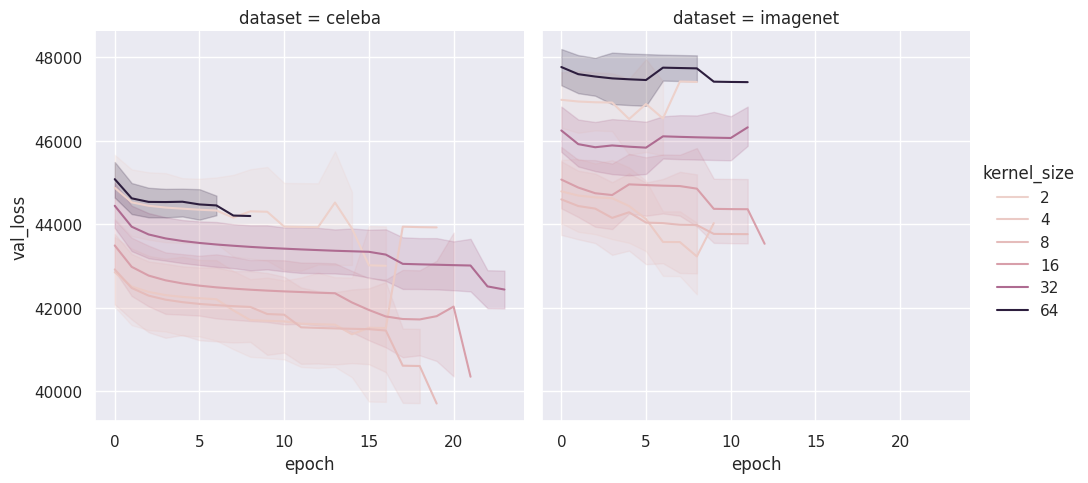

In [63]:
sb.relplot(metrics.dropna(subset="val_loss"), kind="line", x="epoch", y="val_loss", hue="kernel_size", col="dataset")

## Bench Patch Color 32

In [19]:
results_patch =open_experiment("bench-colour-patch-32")

results_patch["runtime"]=results_patch["end_datetime"]-results_patch["start_datetime"]
results_patch = results_patch.reset_index(drop=True)

In [20]:
results_patch.sort_values("test_loss")

,epoch,flops_test,flops_train,max_test_memory,max_train_memory,number_parameters,step,test_bpd,test_loss,train_loss,...,experiment_path,image_size,kernel_size,layer_type,lr,num_units,region_graph,start_datetime,end_datetime,runtime
4,13.0,618.508878,1855.526633,7.831160,8.790296,4.195328e+07,3809.0,5.280949,11244.979492,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",4,cp-t,0.05,1024,quad-graph,2025-12-03 10:08:22.267300,2025-12-03 10:22:33.623112,0 days 00:14:11.355812
59,14.0,154.635633,463.906898,3.797100,4.237674,1.363661e+07,4102.0,5.347980,11387.709961,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",4,cp-t,0.05,512,quad-graph,2025-12-03 10:08:38.162271,2025-12-03 10:17:01.034474,0 days 00:08:22.872203
70,12.0,240.534946,721.604837,5.767458,5.153779,2.726400e+07,3516.0,5.368626,11431.672852,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",4,cp-t,0.05,1024,quad-tree-2,2025-12-03 10:17:17.303150,2025-12-03 10:24:44.598010,0 days 00:07:27.294860
51,12.0,704.383033,2113.149100,12.647194,12.314076,1.803981e+08,3516.0,5.387887,11472.687500,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",8,cp-t,0.05,1024,quad-graph,2025-12-03 10:08:23.593849,2025-12-03 10:28:11.257280,0 days 00:19:47.663431
5,18.0,1168.264692,3504.794075,12.932485,14.629685,7.550771e+07,5274.0,5.412843,11525.826172,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",4,cp,0.05,1024,quad-graph,2025-12-03 10:24:42.523035,2025-12-03 10:49:44.962898,0 days 00:25:02.439863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,6.0,320.243762,960.731285,30.418685,40.361024,1.475696e+09,1758.0,6.078211,12942.627930,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",32,cp,0.05,512,quad-graph,2025-12-03 10:23:52.136298,2025-12-03 11:11:26.002757,0 days 00:47:33.866459
36,7.0,8.581579,25.744736,3.465512,3.981131,1.341851e+08,2051.0,6.082754,12952.299805,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",32,cp,0.05,128,quad-tree-2,2025-12-03 10:27:56.550075,2025-12-03 10:32:00.745995,0 days 00:04:04.195920
75,6.0,34.326249,102.978748,7.691275,9.414919,3.354135e+08,1758.0,6.092803,12973.698242,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",32,cp,0.05,256,quad-tree-2,2025-12-03 10:31:48.117752,2025-12-03 10:47:18.698569,0 days 00:15:30.580817
2,6.0,137.304867,411.914600,18.556230,24.709059,9.390003e+08,1758.0,6.101746,12992.742188,NaN,...,experiments/bench-colour-patch-32/,"(32, 32)",32,cp,0.05,512,quad-tree-2,2025-12-03 10:34:05.160942,2025-12-03 10:53:16.385189,0 days 00:19:11.224247


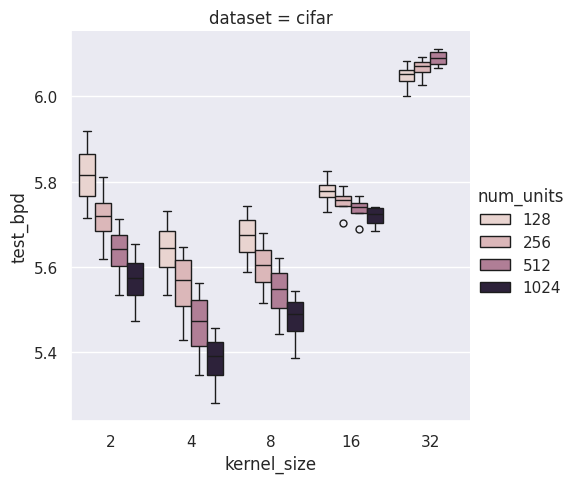

In [20]:
sb.catplot(results_patch, x="kernel_size", y="test_bpd",kind="box", hue="num_units", col="dataset",sharey=False)


## Bench PIC Colour

In [18]:
results_pic =open_experiment("bench-pic-colour")

results_pic["runtime"]=results_pic["end_datetime"]-results_pic["start_datetime"]
results_pic = results_pic.reset_index(drop=True)

In [43]:
results_pic[results_pic["dataset"]=="imagenet"].sort_values("test_loss")

,epoch,flops_test,flops_train,max_test_memory,max_train_memory,number_parameters,step,test_bpd,test_loss,train_loss,...,image_size,kernel_size,layer_type,lr,num_units,region_graph,use_pic,start_datetime,end_datetime,runtime
59,6.0,731.891108,1908.044206,12.646446,9.881659,1315326.0,180162.0,6.199366,52802.433594,NaN,...,"(64, 64)",16,cp-t,0.005,512,quad-graph,True,2025-12-03 19:59:29.133940,2025-12-04 06:26:13.299984,0 days 10:26:44.166044
171,8.0,537.278554,1395.610370,9.299030,6.787130,953470.0,240216.0,6.201134,52817.496094,NaN,...,"(64, 64)",8,cp-t,0.005,512,quad-graph,True,2025-12-03 18:53:45.437550,2025-12-04 11:13:03.676591,0 days 16:19:18.239041
203,8.0,760.751071,2031.399748,12.826189,10.381733,1117950.0,240216.0,6.221411,52990.203125,NaN,...,"(64, 64)",8,cp,0.005,512,quad-graph,True,2025-12-05 23:18:49.083125,2025-12-06 13:10:38.780612,0 days 13:51:49.697487
227,6.0,2261.842395,5954.181530,31.292357,20.269971,1085311.0,180162.0,6.241222,53158.941406,NaN,...,"(64, 64)",8,cp,0.005,1024,quad-tree-2,True,2025-12-07 02:18:57.102299,2025-12-07 11:47:49.175984,0 days 09:28:52.073685
98,8.0,756.452164,1992.196358,12.497564,10.502719,1447167.0,240216.0,6.243496,53178.304688,NaN,...,"(64, 64)",16,cp,0.005,512,quad-tree-2,True,2025-12-06 19:53:43.232413,2025-12-07 09:16:50.979063,0 days 13:23:07.746650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,4.0,21.676491,60.667134,1.400552,1.502868,529934.0,120108.0,6.748425,57478.984375,NaN,...,"(64, 64)",2,cp,0.010,128,quad-graph,True,2025-12-05 10:23:44.802737,2025-12-05 14:23:10.234863,0 days 03:59:25.432126
47,4.0,241.894425,656.292184,5.027795,3.975402,528135.0,120108.0,6.756057,57543.988281,NaN,...,"(64, 64)",2,cp,0.010,512,quad-tree-2,True,2025-12-06 16:46:40.871101,2025-12-06 19:50:33.255356,0 days 03:03:52.384255
71,6.0,60.549235,164.266246,1.914546,1.795790,528135.0,180162.0,6.761825,57593.117188,NaN,...,"(64, 64)",2,cp,0.010,256,quad-tree-2,True,2025-12-06 11:27:31.111655,2025-12-06 16:50:26.549279,0 days 05:22:55.437624
105,5.0,6.543245,17.431790,0.705171,0.598534,395523.0,150135.0,6.778191,57732.511719,NaN,...,"(64, 64)",2,cp-t,0.010,128,quad-tree-2,True,2025-12-04 06:50:10.705149,2025-12-04 08:58:35.946690,0 days 02:08:25.241541


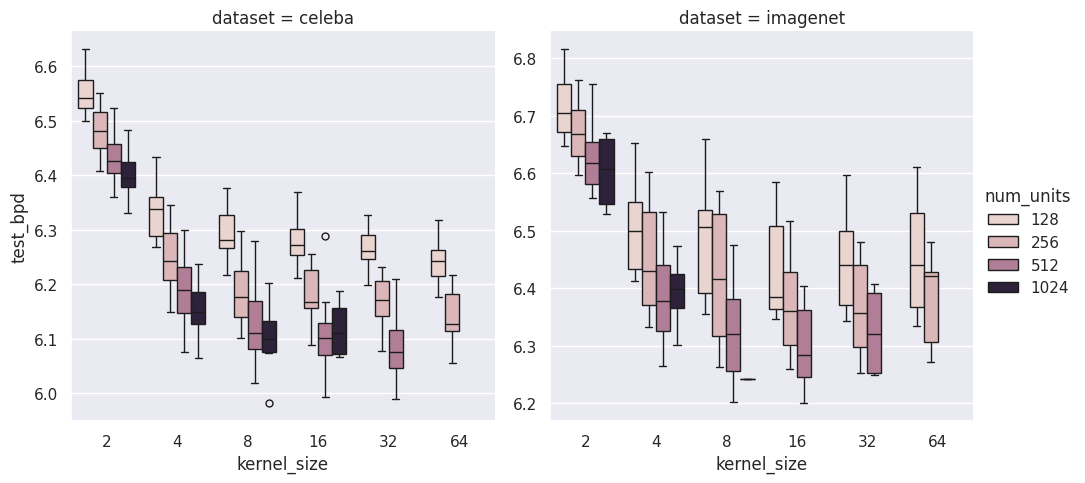

In [19]:
sb.catplot(results_pic, x="kernel_size", y="test_bpd",kind="box", hue="num_units", col="dataset",sharey=False)


## Benchmark composite circuits

In [58]:
results_compo =open_experiment("bench-composite")
results_compo["dataset"].unique()

array(['mnist', 'cifar'], dtype=object)

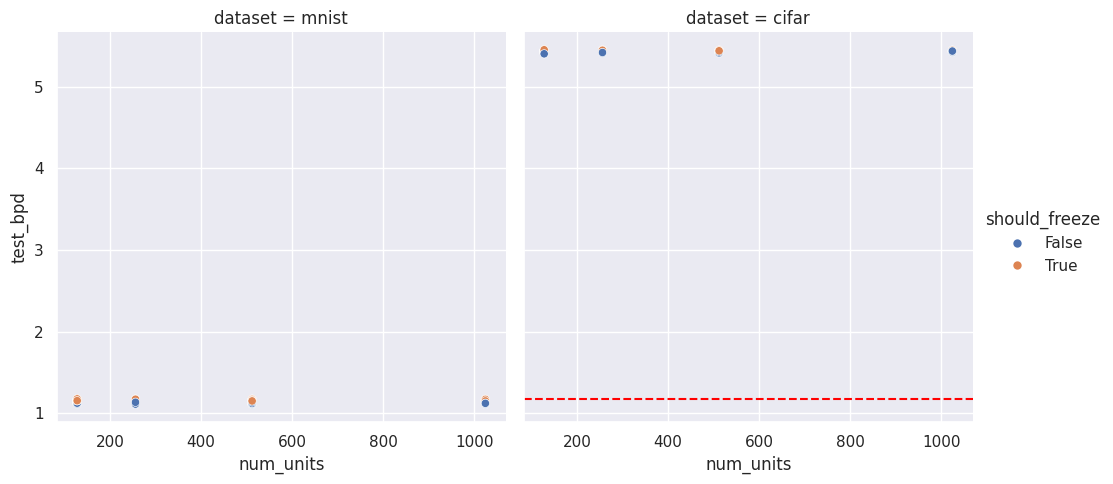

In [ ]:
sb.relplot(results_compo, x="num_units", y="test_bpd", col="dataset", hue="should_freeze",
    facet_kws=dict(sharey=False),
)
lowest = results_high[results_high["dataset"]=="mnist"]["test_bpd"].min()
# plt.axhline(y=lowest, c="red", ls="--", label="Previous best model")
for ax in g.axes.flat:
    ax.axhline(10, color="red", linestyle="--")

# Tune

In [38]:
import pandas as pd

df = pd.read_csv("/home/chbricout/Downloads/CIFAR_patch_search/results_summary.csv")
config_col = []
for col in df.columns:
    if "config/" in col:
        config_col.append(col)
search_df=df[[*config_col, "val_bpd", "timestamp"]]
search_df

,config/layer_type,config/region_graph,config/kernel_size,config/num_units,config/lr,config/circuit_type,config/dataset,config/batch-size,config/image_size,config/channel,val_bpd,timestamp
0,cp-t,quad-tree-2,"[16, 16]",22,0.003528,patch,cifar,128,"[32, 32]",3,7.664769,1763640393
1,cp,quad-tree-2,"[32, 32]",26,0.002354,patch,cifar,128,"[32, 32]",3,7.949292,1763640408
2,cp,quad-graph,"[8, 8]",17,0.000914,patch,cifar,128,"[32, 32]",3,7.979972,1763640409
3,cp,quad-tree-2,"[8, 8]",629,0.000508,patch,cifar,128,"[32, 32]",3,7.949623,1763640590
4,cp-t,quad-tree-2,"[32, 32]",11,0.003438,patch,cifar,128,"[32, 32]",3,7.960369,1763640584
...,...,...,...,...,...,...,...,...,...,...,...,...
95,cp,quad-graph,"[4, 4]",500,0.045775,patch,cifar,128,"[32, 32]",3,5.804392,1763738548
96,cp,quad-graph,"[4, 4]",496,0.059068,patch,cifar,128,"[32, 32]",3,5.737251,1763740963
97,cp,quad-graph,"[4, 4]",587,0.058743,patch,cifar,128,"[32, 32]",3,5.731267,1763741981
98,cp,quad-graph,"[4, 4]",607,0.041763,patch,cifar,128,"[32, 32]",3,5.782987,1763742142


<Axes: xlabel='timestamp', ylabel='val_bpd'>

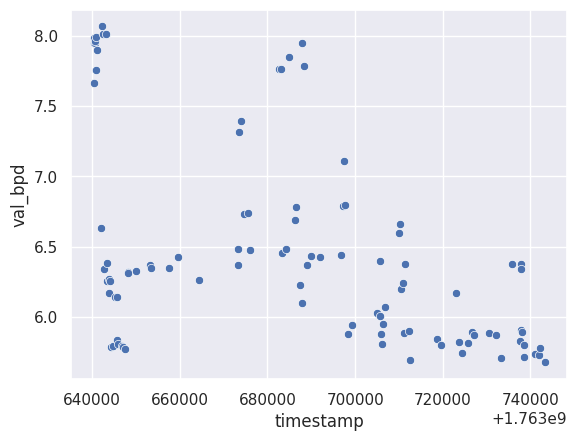

In [39]:
import seaborn as sb
sb.set_theme()

sb.scatterplot(search_df, x="timestamp", y="val_bpd")

In [40]:
df=pd.read_csv("/home/chbricout/Downloads/metrics.csv")
df

,epoch,step,train_loss,val_loss
0,0,199,57803.546875,NaN
1,0,399,51153.960938,NaN
2,0,599,50404.343750,NaN
3,0,799,49110.382812,NaN
4,0,999,48667.593750,NaN
...,...,...,...,...
796,58,147799,43761.878906,NaN
797,58,147999,43173.906250,NaN
798,58,148199,43030.156250,NaN
799,58,148399,43570.171875,NaN


<Axes: xlabel='epoch', ylabel='val_loss'>

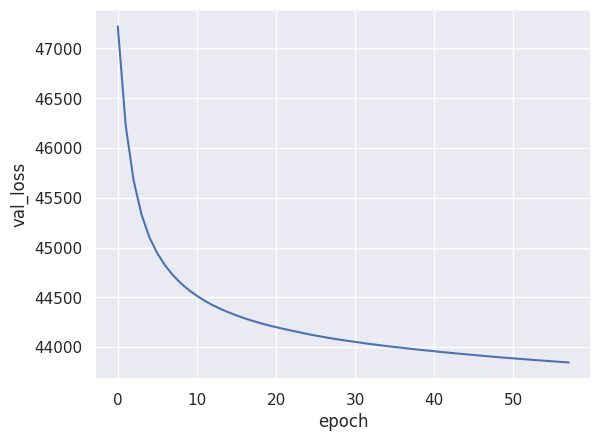

In [41]:
sb.lineplot(df, x="epoch", y="val_loss")

<Axes: xlabel='step', ylabel='train_loss'>

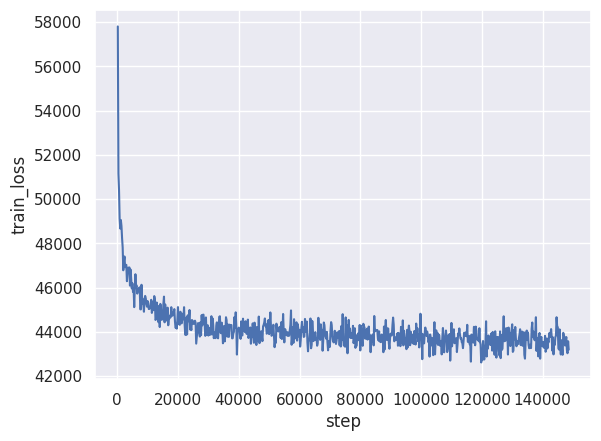

In [42]:
sb.lineplot(df, x="step", y="train_loss")